In [41]:
import pathlib
import sys

import numpy as np
import netCDF4
import colorcet
import cmocean


import matplotlib.patches
import matplotlib.pyplot as plt
import scipy.interpolate
import skimage.draw
import skimage.exposure
import tqdm

local_path = pathlib.Path('~/.local/lib/python3.5/site-packages').expanduser()
sys.path.append(str(local_path))
import cv2
import io
import requests

%matplotlib inline


In [42]:
path = pathlib.Path('~/models/c020_pillar/pillar.mdu').expanduser()
nc_path = path.parent / 'dflowfmoutput' / 'pillar_map.nc'


In [43]:
def seed(img):
    """insert seed points in img"""
    for row in range(10, 590, 50):
        rr, cc = skimage.draw.circle(row, 10, 3, shape=img.shape)
        img[rr, cc] = 1.0

class CylinderGrid(object):
    """a combination of a FM grid, a flow grid and a pole"""
    def __init__(self, nc_path, zoom=3.5):
        self.nc_path = nc_path
        self.pole = self.create_pole()
        self.grid = self.create_grid(self.nc_path, self.pole)
        self.flow_grid = self.create_flow_grid(zoom)
        self.F = self.create_interpolation(self.grid["points"], self.pole)
        self.t_idx = 0

    @property
    def uv_0(self):
        u_0 = self.grid['mesh2d_ucx'][self.t_idx]
        v_0 = self.grid['mesh2d_ucy'][self.t_idx]
        uv_0 = np.c_[u_0, v_0]
        return uv_0
    @property
    def uv_1(self):
        u_1 = self.grid['mesh2d_ucx'][self.t_idx + 1]
        v_1 = self.grid['mesh2d_ucy'][self.t_idx + 1]
        uv_1 = np.c_[u_1, v_1]
        return uv_1

    @staticmethod
    def create_pole():
        """create a concrete pole"""
        def download_concrete_img():
            url = 'http://texturelib.com/Textures/concrete/floor/concrete_floor_0056_01_preview.jpg'
            url = 'http://img.cadnav.com/allimg/130905/1-130Z5012G2250.jpg'
            resp = requests.get(url)

            bytes = io.BytesIO(resp.content)
            concrete = plt.imread(bytes, format='jpg')
            concrete = skimage.exposure.adjust_sigmoid(concrete, cutoff=0.4, gain=12)
            concrete_rgba = np.dstack([
                concrete[:450, :450].astype('float32')/255.0, 
                np.zeros((450, 450), dtype='float32')
            ])


            r = concrete_rgba.shape[0]/2
            rr, cc = skimage.draw.circle(r, r, r, concrete_rgba.shape)
            concrete_rgba[rr, cc, 3] = 1.0
            return concrete_rgba
        pole = {}
        pole['xy'] = (0, 1500)
        pole['r'] = 3.0
        pole['extent'] = (
            pole['xy'][0] - pole['r'], 
            pole['xy'][0] + pole['r'], 
            pole['xy'][1] - pole['r'], 
            pole['xy'][1] + pole['r']
        )
        pole['circle'] = matplotlib.patches.Circle(
            pole['xy'], 
            pole['r'], 
            facecolor='none', 
            edgecolor='#223344', 
            linewidth=3, 
            zorder=10
        )
        # get the path
        pole['path'] = pole['circle'].get_path()
        pole['transform'] = pole['circle'].get_transform()
        pole['concrete'] = download_concrete_img()
        def points_in_pole(points):
            in_pole = pole['path'].contains_points(points, transform=pole['transform'])
            return in_pole
        pole['points_in_pole'] = points_in_pole

        return pole
    
    @staticmethod
    def create_grid(nc_path, pole):
        ds = netCDF4.Dataset(nc_path)
        grid = {}
        grid['pole'] = pole
        for var in ['mesh2d_face_x', 'mesh2d_face_y', 
                    'mesh2d_node_x', 'mesh2d_node_y', 'mesh2d_node_z',
                    'mesh2d_edge_x', 'mesh2d_edge_y',
                    'mesh2d_edge_x_bnd', 'mesh2d_edge_y_bnd',
                    'mesh2d_face_x_bnd', 'mesh2d_face_y_bnd',
                    'mesh2d_edge_type',
                    'mesh2d_edge_nodes', 'mesh2d_face_nodes', 
                    'mesh2d_ucx', 'mesh2d_ucy', 'time']:
            grid[var] = ds.variables[var][:]

        # define interpolation function
        points = np.c_[grid['mesh2d_face_x'], grid['mesh2d_face_y']]
        grid['points'] = points

        return grid
    
    @staticmethod
    def create_flow_grid(zoom):
        """create flow grid"""
        # zoom extent
        # define interpolation grid
        d = zoom
        Y, X = np.mgrid[1500-2*d:1500+2*d:600j, -2*d:10*d:800j]
        y, x = np.ogrid[1500-2*d:1500+2*d:600j, -2*d:10*d:800j]
        x = np.squeeze(x)
        y = np.squeeze(y)
        points = np.c_[X.ravel(), Y.ravel()]
        dy = (y[1] - y[0]) # m/px
        dx = (x[1] - x[0]) # m/px

        flow_grid = {
            "X": X,
            "Y": Y,
            "x": x,
            "y": y,
            "dx": dx,
            "dy": dy,
            "points": points
        }
        return flow_grid
    
    @staticmethod
    def create_interpolation(points, pole):
        """create an interpolation function that interpolates around a pole"""
        # create a 0 uv vector
        uv = np.zeros_like(points)
        # create an extra ring inside the pole, so we can interpolate to 0
        r = pole['r'] * 0.99
        x, y = pole['xy']
        # define extra points, based on a circle
        angles = np.linspace(0, np.pi*2, num=100, endpoint=False)
        # and a radius, just inside the pole
        extra_points = np.c_[np.cos(angles)*r + x, np.sin(angles)*r + y ]
        # zet all these velocities to 0
        extra_uv = np.zeros_like(extra_points)

        points = np.vstack([points, extra_points])
        uv = np.vstack([uv, extra_uv])
        F = scipy.interpolate.CloughTocher2DInterpolator(
            points,
            uv
        )
        return F
    
    def update_interpolation(self, uv):
        """update interpolation function with new uv's"""
        grid = self.grid
        F = self.F
        F.values[:uv.shape[0],:] = uv
        return F
    
    def iter_uv(self, i=0):
        grid = self.grid
        for t_idx in range(i, grid['time'].shape[0] - 1):
            self.t_idx = t_idx
            t0 = self.grid['time'][t_idx]
            t1 = self.grid['time'][t_idx + 1]
            # lookup velocities
            t_i = t0
            # only needed if we're iterating over more times
            frac = (t_i - t0)/(t1 - t0)
            # should be 1*uv_0 now
            uv_i = (1 - frac) * self.uv_0 + frac * self.uv_1
            F = self.update_interpolation(uv_i)
            UV_i = F(self.flow_grid['points']).reshape(self.flow_grid['X'].shape + (2,))
            yield t_i, UV_i
    
    def uv2flow(self, uv, dt=1.0, scale=1.0):
        """compute how many pixels we need to flow"""
        dx = self.flow_grid['dx']
        dy = self.flow_grid['dy']
        # m/s * s -> m
        flow = uv * dt
        # arbitrary scale vector
        flow *= scale
        # m / m/px -> px
        flow[..., 0] /= dx
        flow[..., 1] /= dy
        return flow.astype('float32')
    
    @staticmethod
    def img_advect(img, flow, seed=seed, n_iter=1):
        """advect the image img with flow field flow"""
        # lookup originating color for next timestep
        h, w = flow.shape[:2]
        flow = -flow
        # add indices
        flow[:,:,0] += np.arange(w)
        flow[:,:,1] += np.arange(h)[:,np.newaxis]
        for i in range(n_iter):
            # reseed img
            seed(img)
            # apply flow field
            img = cv2.remap(img, flow, None, cv2.INTER_LINEAR)
        return img



In [44]:
# loop over t and t+1

def make_checkerboard(X, Y):
    blocksize = 2
    img = np.logical_xor(np.mod(Y, blocksize) < blocksize/2, np.mod(X, blocksize) < blocksize/2).astype('float32')
    return img


In [61]:
class Visualization(object):
    def __init__(self, grid):
        self.grid = grid
        self.fig, self.ax = plt.subplots(figsize=(13, 8))
        self.img = self.create_img()
        self.im_img = self.create_im_img()
        self.im_concrete = self.create_im_concrete()
        self.patch_cylinder = self.create_patch_cylinder()
        # self.lc_grid = self.create_grid()
        self.ax.axis('equal')

    def create_img(self):
        """create the image"""
        img = np.zeros(grid.flow_grid['X'].shape, dtype='float32')
        return img

    def create_im_img(self):
        """create an imshow for img"""
        grid = self.grid
        x, y = grid.flow_grid['x'], grid.flow_grid['y']
        extent = (x.min(), x.max(), y.min(), y.max())
        im_img = self.ax.imshow(self.img, extent=extent, cmap=colorcet.m_kgy, vmin=0, vmax=0.4)
        return im_img
    
    def create_grid(self):
        grid = self.grid
        edge_x = grid.grid['mesh2d_node_x'][grid.grid['mesh2d_edge_nodes']-1]
        edge_y = grid.grid['mesh2d_node_y'][grid.grid['mesh2d_edge_nodes']-1]

        edges = np.dstack([edge_x, edge_y])
        lines = matplotlib.collections.LineCollection(
            edges, colors='white',
            linewidths=1.0, alpha=0.4,
            zorder=8
        )
        lc_grid = self.ax.add_collection(lines) 
        return lc_grid
    def create_im_concrete(self):
        pole = self.grid.pole
        im_concrete = self.ax.imshow(pole['concrete'], extent=pole['extent'], zorder=9)
        return im_concrete
    
    def create_patch_cylinder(self):
        pole = self.grid.pole
        patch_cylinder = self.ax.add_patch(pole['circle'])
        return patch_cylinder


In [58]:
# ax.streamplot(
#     x, 
#     y, 
#     UV[..., 0],
#     UV[..., 1], 
#     density=2,
#     linewidth=np.sqrt(UV[..., 0]**2 + UV[..., 1]**2)*3,
#     color='#33445533',
#     minlength=0.1
# )



(1495, 1505)

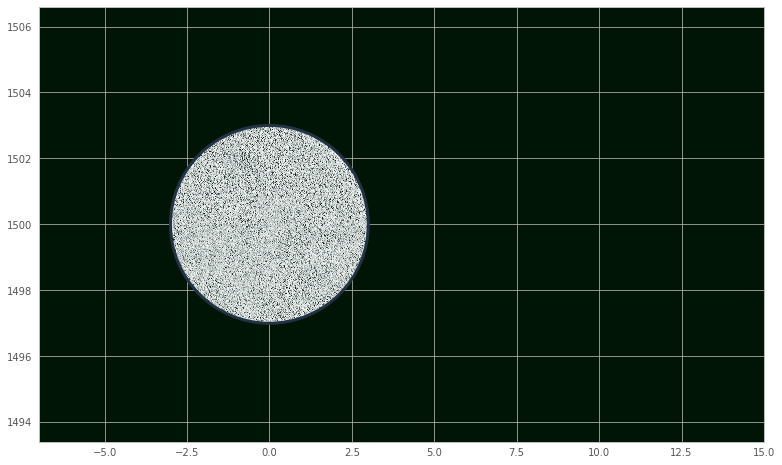

In [62]:
grid = CylinderGrid(nc_path)
vis = Visualization(grid)
vis.ax.set_xlim(-7, 15)
vis.ax.set_ylim(1495, 1505)

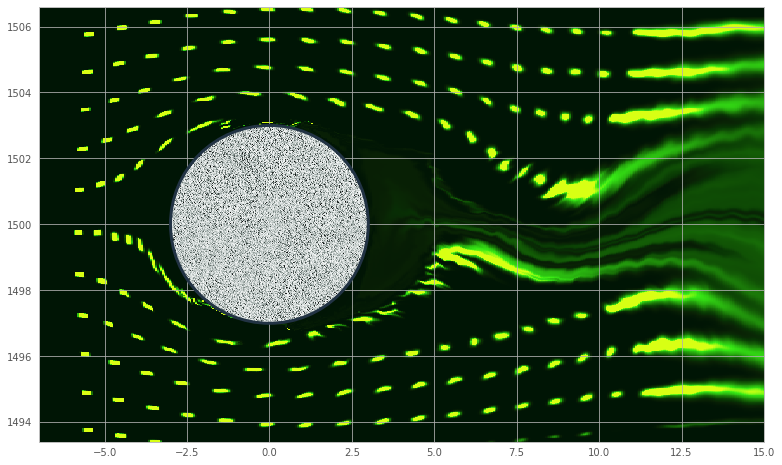

In [67]:
d = 2.5

# convert to pixel speed
dt = 1.0 
for i, (t_i, uv) in enumerate(grid.iter_uv(i=10)):
    # reseed
    flow = grid.uv2flow(uv, dt=1, scale=1)
    vis.img = grid.img_advect(vis.img, flow, n_iter=1)
    vis.im_img.set_data(vis.img)
    if i > 20:
        break
        
vis.fig

